In [2]:
import pandas as pd

In [3]:




def do_ranking(melted_df):

    def rank_accuracies(group):
        # Sort by accuracy
        sorted_group = group.sort_values('accuracy')
        # Compute ranks
        sorted_group['rank'] = sorted_group['accuracy'].rank(method='average')
        return sorted_group

    # Apply ranking within each dataset_name
    ranked_df = melted_df.groupby('dataset_name').apply(rank_accuracies).reset_index(drop=True)

    # Compute average rank per classifier
    average_rank_per_classifier = ranked_df.groupby('classifier_name')['rank'].mean().reset_index()
    average_rank_per_classifier = average_rank_per_classifier.sort_values(by='rank', ascending=True).reset_index(drop=True)

    # Extract lists
    classifier_names = average_rank_per_classifier['classifier_name'].tolist()
    average_ranks = average_rank_per_classifier['rank'].tolist()

    # Display the lists
    print("Classifier Names:", classifier_names)
    print("Average Ranks:", average_ranks)

    # Return the DataFrame sorted by average rank
    return average_rank_per_classifier, classifier_names, average_ranks


In [4]:
# Input is simply the values of the groups in order per dataset e.g dct, dft, and dwt or the Model-Names 
import numpy as np
from scipy.stats import friedmanchisquare

# Example data: 4 subjects, 3 treatments
data = np.array([
    [8, 7, 6],  # Subject 1
    [6, 6, 5],  # Subject 2
    [7, 5, 6],  # Subject 3
    [9, 8, 7]   # Subject 4
])

# Perform the Friedman test
statistic, p_value = friedmanchisquare(data[:, 0], data[:, 1], data[:, 2])

print(f"Friedman test statistic: {statistic}")
print(f"P-value: {p_value}")

Friedman test statistic: 5.733333333333333
P-value: 0.056888238346101516


In [12]:
#path = 'rmse_FLAML Results_count_df_with_0dval.csv'

path = 'msmape_FLAML Results_count_df.csv'

#path = 'rmse_FLAML Results_count_df.csv'  # -> best so far! see that dct is bad

#path = 'msmape_FLAML Results_count_df_with_0dval.csv'


df_perf = pd.read_csv(path, index_col=False)

# do_ranking ranks after lower values! lower error!
df_perf['accuracy'] = df_perf['accuracy'] * -1

ranked , classifiers, average_ranks = do_ranking(df_perf)
ranked

Classifier Names: ['dwt', 'dft', 'dct']
Average Ranks: [1.3125, 2.0, 2.6875]


/tmp/ipykernel_96714/1662295018.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ranked_df = melted_df.groupby('dataset_name').apply(rank_accuracies).reset_index(drop=True)


,classifier_name,rank
0,dwt,1.3125
1,dft,2.0000
2,dct,2.6875


In [13]:
df_perf

,classifier_name,dataset_name,accuracy
0,dwt,AppliancesEnergy,-4
1,dft,AppliancesEnergy,-3
2,dct,AppliancesEnergy,-3
3,dwt,NewsTitleSentiment,-1
4,dft,NewsTitleSentiment,-2
5,dct,NewsTitleSentiment,-1
6,dwt,BenzeneConcentration,-6
7,dft,BenzeneConcentration,-2
8,dct,BenzeneConcentration,-3
9,dwt,BeijingPM25Quality,-6


In [14]:
def perform_friedman_test(df, alpha=0.05):
    """
    Perform the Friedman test to compare classifiers based on accuracy.

    Parameters:
    df (pd.DataFrame): DataFrame with columns 'classifier_name', 'dataset_name', and 'accuracy'.
    alpha (float): Significance level for the test. Default is 0.05.

    Returns:
    None: Prints the Friedman test results and interpretation.
    """
    # Pivot the DataFrame to have each dataset as rows and classifiers as columns
    df_pivot = df.pivot_table(index='dataset_name', columns='classifier_name', values='accuracy')

    # Drop any rows with NaN values (if there are any datasets without all classifiers)
    df_pivot = df_pivot.dropna()

    # Check the reshaped DataFrame
    print(df_pivot)

    # Perform the Friedman test
    classifiers = df_pivot.columns
    if len(classifiers) < 2:
        raise ValueError("At least two classifiers are required to perform the Friedman test.")
    
    # Extract accuracy values for each classifier
    test_args = [df_pivot[classifier] for classifier in classifiers]
    stat, p_value = friedmanchisquare(*test_args)

    # Print the Friedman test statistic and p-value
    print(f'Friedman test statistic: {stat}')
    print(f'p-value: {p_value}')

    # Interpret the result
    if p_value < alpha:
        print(f'There is a significant difference between the classifiers (alpha = {alpha}).')
    else:
        print(f'There is no significant difference between the classifiers (alpha = {alpha}).')

perform_friedman_test(df_perf, 0.05)

classifier_name             dct  dft  dwt
dataset_name                             
AppliancesEnergy           -3.0 -3.0 -4.0
BeijingPM25Quality         -3.0 -5.0 -6.0
BenzeneConcentration       -3.0 -2.0 -6.0
Covid3Month                -1.0 -1.0 -2.0
FloodModeling1              0.0 -1.0 -6.0
HouseholdPowerConsumption1 -2.0 -3.0 -3.0
IEEEPPG                     0.0 -1.0 -1.0
NewsTitleSentiment         -1.0 -2.0 -1.0
Friedman test statistic: 8.962962962962964
p-value: 0.011316635344033292
There is a significant difference between the classifiers (alpha = 0.05).


In [15]:
""" classifiers = [
    'Rocket', 'AutoGluon', 'FCN', 'XGBoost', 'FLAML', 'Random Forest',
    'ResNet', 'Inception', 'FPCR', 'FPCR-Bspline', '5-NN-DTWD', 
    '5-NN-ED', 'SVR Optimised', 'SVR', '1-NN-DTWD', '1-NN-ED'
]

average_ranks = [
    4.454545454545454, 5.7272727272727275, 6.090909090909091, 
    6.090909090909091, 6.2272727272727275, 6.636363636363637, 
    6.7272727272727275, 6.818181818181818, 9.090909090909092, 
    9.318181818181818, 9.363636363636363, 10.545454545454545, 
    10.954545454545455, 12.409090909090908, 12.545454545454545, 
    13.0
] """

" classifiers = [\n    'Rocket', 'AutoGluon', 'FCN', 'XGBoost', 'FLAML', 'Random Forest',\n    'ResNet', 'Inception', 'FPCR', 'FPCR-Bspline', '5-NN-DTWD', \n    '5-NN-ED', 'SVR Optimised', 'SVR', '1-NN-DTWD', '1-NN-ED'\n]\n\naverage_ranks = [\n    4.454545454545454, 5.7272727272727275, 6.090909090909091, \n    6.090909090909091, 6.2272727272727275, 6.636363636363637, \n    6.7272727272727275, 6.818181818181818, 9.090909090909092, \n    9.318181818181818, 9.363636363636363, 10.545454545454545, \n    10.954545454545455, 12.409090909090908, 12.545454545454545, \n    13.0\n] "

1.1718505


/tmp/ipykernel_96714/1142273184.py:17: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = scoring.compute_CD(avranks,num_ds , alpha='0.05', test=test)
/tmp/ipykernel_96714/1142273184.py:19: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  scoring.graph_ranks(avranks, names, cd, width=6, textspace=1.5)


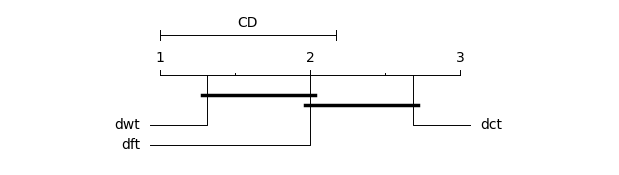

In [16]:
import importlib
from Orange.evaluation import scoring
_ = importlib.reload( scoring )

names = ["first", "third", "second", "fourth" ]
avranks =  [1.9, 3.2, 2.8, 3.3 ] 

names = classifiers
avranks = average_ranks

test = 'nemenyi'
#test = 'bonferroni-dunn'

num_ds = 8
#num_ds = 11

cd = scoring.compute_CD(avranks,num_ds , alpha='0.05', test=test) 
print(cd)
scoring.graph_ranks(avranks, names, cd, width=6, textspace=1.5)